# ResNet i przenoszenie uczenia

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models, callbacks
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.15.1
[]


## Przygotowanie zestawu danych CIFAR10
Przykłady w tym zbiorze mają format 32 na 32 punkty i są kolorowe, a więc posiadają trzy kanały.

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Weryfikacja przykładów

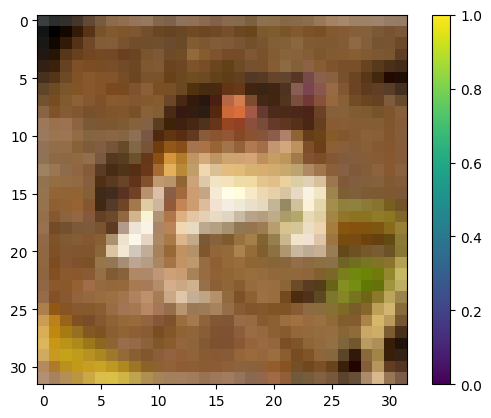

(32, 32, 3)


In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

input_shape = train_images[0].shape
if len(input_shape) < 3:
    input_shape += tuple([1])
print(input_shape)

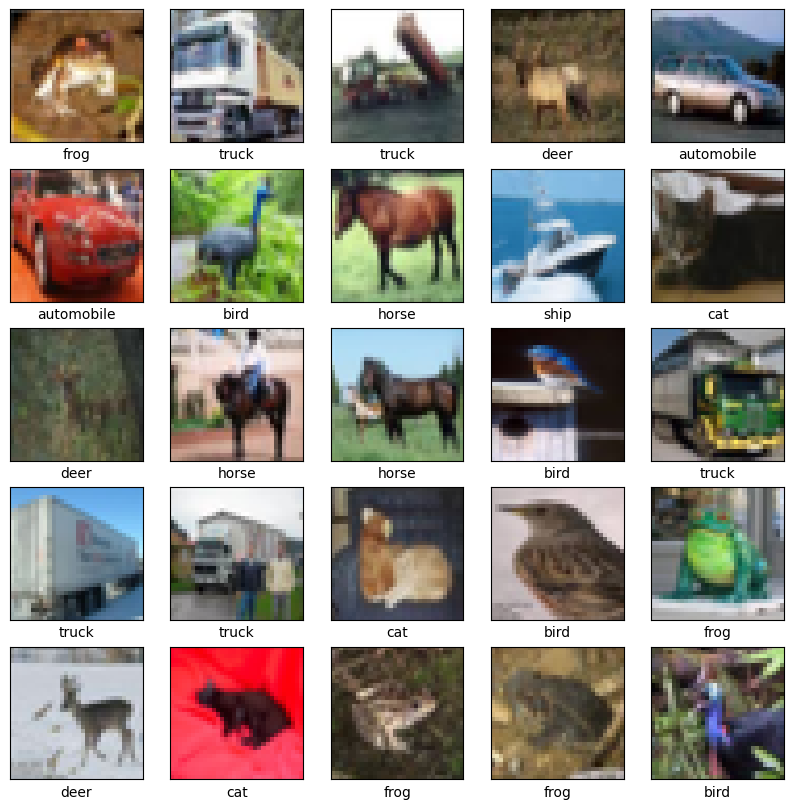

10

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()
len(class_names)

### Wstępne przetwarzanie

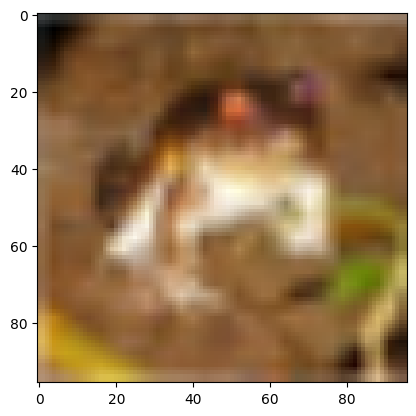

In [7]:
IMG_SIZE = 96
input_resize = layers.Resizing(IMG_SIZE, IMG_SIZE)

plt.imshow(input_resize(train_images[0]))

## Blok resztkowy

In [9]:
class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

### ResNet-18

In [13]:
def b1():
    return tf.keras.models.Sequential([
               layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
               layers.MaxPool2D(pool_size=3, strides=2, padding='same')
    ])

def resnet_module(num_residuals, num_channels, first_block=False):
    blk = tf.keras.models.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

def resnet(arch, classifier_input, num_classes):
    net = tf.keras.models.Sequential([
        tf.keras.Input(shape=classifier_input),
        input_resize,
        b1()
    ])
    
    for i, b in enumerate(arch):
        net.add(resnet_module(*b, first_block=(i==0)))
        
    net.add(tf.keras.models.Sequential([
        layers.GlobalAvgPool2D(),
        layers.Dense(units=num_classes)]
    ))
    return net

def resnet_18(classifier_input, num_classes):
    return resnet(((2, 64), (2, 128), (2, 256), (2, 512)),
                       classifier_input, num_classes)


### Wybór modelu

In [14]:
model = resnet_18(input_shape, len(class_names))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 sequential (Sequential)     (None, 24, 24, 64)        9472      
                                                                 
 sequential_2 (Sequential)   (None, 24, 24, 64)        148736    
                                                                 
 sequential_3 (Sequential)   (None, 12, 12, 128)       526976    
                                                                 
 sequential_4 (Sequential)   (None, 6, 6, 256)         2102528   
                                                                 
 sequential_5 (Sequential)   (None, 3, 3, 512)         8399360   
                                                                 
 sequential_6 (Sequential)   (None, 10)               

### Skład i trening modelu
Kluczowym parametrem na tym etapie jest współczynnik uczenia. Zwykle najlepszym wyborem na początek jest wartość rzędu 0.0001 zmniejszana, w miarę jak postępuje uczenie. Moment na zmianę współczynnika rozpoznaje się po zaprzestaniu spadania wartości trafności na zbiorze walidacyjnym. Przy małej liczbie epok, takiej jak zastosowano poniżej, można poszczególne etapy uczenia dostosować ręcznie, natomiast w przypadku wielu epok, rzędu co najmniej kilkudziesięciu, stosuje się rozwiązania zautomatyzowane i wtedy przeważnie stosuje się początkowo większą wartość, rzędu 0.01. Daje to algorytmowi swobodę doboru, choć oznacza to także, że pierwsze kilkanaście epok zostanie zmarnowane wyłącznie na poszukiwanie właściwego współczynnika, bo bardzo rzadko zdarza się, żeby jakakolwiek sieć była się w stanie przy takiej wartości czegoś się nauczyć.

In [50]:
def lr_schedule(epoch):
    if epoch < 3 :
        lr = 0.0001 #5e-4
    elif epoch >= 3 and epoch <5:
        lr = 0.00001 #5e-5
    else:
        lr = 0.000001 #1e-5
    return lr

lr_reducer = callbacks.LearningRateScheduler(lr_schedule)

In [83]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels),
                    #callbacks=[lr_reducer],
                    #batch_size=256
                    )

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.4202 - loss: 1.5988 - val_accuracy: 0.5089 - val_loss: 1.4532
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.6597 - loss: 0.9632 - val_accuracy: 0.6172 - val_loss: 1.1304
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.7521 - loss: 0.7009 - val_accuracy: 0.6957 - val_loss: 0.9109
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8267 - loss: 0.4989 - val_accuracy: 0.7302 - val_loss: 0.8040
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.8849 - loss: 0.3282 - val_accuracy: 0.6104 - val_loss: 1.4111
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9248 - loss: 0.2179 - val_accuracy: 0.6465 - val_loss: 1.2679
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9517 - loss: 0.1442 - val_accuracy: 0.7215 - val_loss: 1.0353
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.9595 -

### Wyniki

313/313 - 2s - 7ms/step - accuracy: 0.7328 - loss: 1.0849


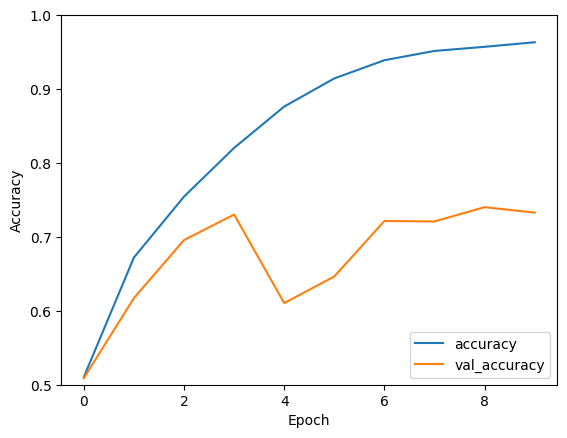

In [84]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [85]:
print(test_acc)

0.7328000068664551


## Zadania
1. Przetestuj inny wariant sieci ResNet i dostosuj go do przyjmowania danych w formacie 32 na 32, spośród opisanych w tabeli 1 z poniższego artykułu:  
    - [https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) (1 pkt)
2. Dodaj przewężenia w architekturze sieci (ang. bottleneck). (1 pkt)
3. W kolejnych udoskonaleniach autorzy zmieniają schemat "splot, normalizacja wsadu i aktywacja" na "normalizacja wsadu, aktywacja i splot". Dodaj to usprawnienie. Jako wzór możesz wykorzystać rysunek 1 z artykułu: https://doi.org/10.1007/978-3-319-46493-0_38 (1 pkt)
4. Wytrenowany model na zbiorze CIFAR-10 naucz rozpoznawać klasy ze zbioru Fashion-MNIST. (1 pkt)
5. Porównaj wyniki osiągane przez model z zadnia 4 z modelem wytrenowanym wyłącznie na zbiorze Fashion-MNIST. Wykorzystaj do tego naturalne przykłady, chociażby te z poprzednich zajęć. (1 pkt)